# Prueba de permutación

Mediante la prueba de permutación vamos a analizar la posible relación entre dos variables. Esta prueba no necesita ningún supuesto sobre la distribución de los datos y es posible (o digamos práctica) si esta disponible poder de cómputo. 

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import random
from scipy.stats import chi2_contingency

Leemos el dataset del titanic. Quiero saber si existe alguna relación entre la edad y la supervivencia. Descarto cualquier otro dato.

In [50]:
df = pd.read_csv("../datasets/titanic.csv")
#df = df[["Age", "Survived"]]
df.shape

(891, 12)

Tenemos algunos nulos, los excluyo de mi análisis.

In [51]:
df["Age"].shape[0]/df["Age"].isnull().sum()

5.033898305084746

In [52]:
df["Age"].dropna(inplace=True)
df.shape

(891, 12)

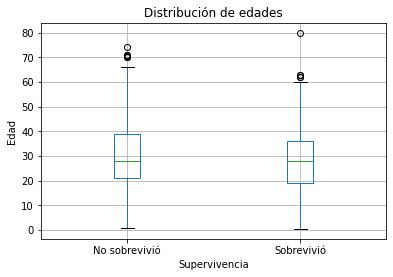

In [53]:
df.boxplot(column="Age", by="Survived")

plt.suptitle("")  # eliminar el título automático
plt.xlabel("Supervivencia")
plt.ylabel("Edad")
plt.xticks([1, 2], ["No sobrevivió", "Sobrevivió"])
plt.title("Distribución de edades")
plt.show()

¿Cual es la edad media de los supervivientes? ¿Cual es la edad media de quienes murieron?

In [54]:
surv_age_mean = df.loc[df.Survived==1, ["Age"]].mean().values[0]
died_age_mean = df.loc[df.Survived==0, ["Age"]].mean().values[0]
obs_diff = surv_age_mean - died_age_mean
print(f"{surv_age_mean:.2f}, {died_age_mean:.2f}, {obs_diff:.2f}")

28.34, 30.63, -2.28


Hay un diferencia de 2.28, ¿Esa diferencia puede ser producto del azar? O es lo suficientemente grande como para expresar una relación.

Para realizar el test permuto los valores de edad, rompo totalmente la relación que pudiese haber entre ellos. Como mantuve los valores de supervivencia intactos la cantidad de supervivientes vs no supervivientes no se altera. Luego calculo n veces las medias de entre los "falsos supervivientes" y "falsos no supervivientes" y las guardo en una lista, esto termina generando una campana, ¿Donde queda mi diferencia observada? ¿Cuantas veces la diferencia fue tan extrema como la observada? 

Diferencia observada: -2.28
p-valor: 0.0400


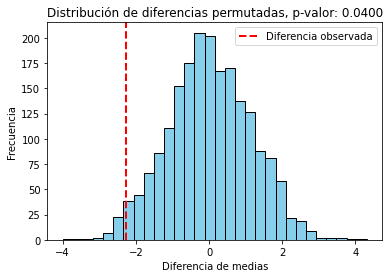

In [55]:
n_permutations = 2000
permuted_diff = []

# Repetir el reordenamiento de etiquetas
for _ in range(n_permutations):

    df['Age_permuted'] = np.random.permutation(df['Age'])
    surv_age_mean = df.loc[df.Survived==1, ["Age_permuted"]].mean().values[0]
    died_age_mean = df.loc[df.Survived==0, ["Age_permuted"]].mean().values[0]
    diff = surv_age_mean - died_age_mean
    permuted_diff.append(diff)

# Paso 4: Calcular el p-valor como la proporción de permutaciones que tienen una diferencia mayor o igual a la observada
p_value = np.sum(np.abs(permuted_diff) >= np.abs(obs_diff)) / n_permutations

# Mostrar los resultados
print(f"Diferencia observada: {obs_diff:.2f}")
print(f"p-valor: {p_value:.4f}")

# Graficar la distribución de las diferencias permutadas
plt.hist(permuted_diff, bins=30, color='skyblue', edgecolor='black')
plt.axvline(obs_diff, color='red', linestyle='dashed', linewidth=2, label='Diferencia observada')
plt.title(f'Distribución de diferencias permutadas, p-valor: {p_value:.4f}')
plt.xlabel('Diferencia de medias')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()

Recordando</BR>
Si p-valor < 0.05, se rechaza la hipótesis nula de independencia.</BR>
Si p-valor >= 0.05, no se rechaza la hipótesis nula.</BR>

Pendiente. Analizar la potencia de la muestra

In [56]:
df.drop(columns=['Age_permuted'], inplace=True)

Veamos con otra variable(la clase)</BR>
Hipótesis nula: la clase del pasajero (Pclass) no está asociada a la supervivencia (Survived), o sea son independientes.</BR>
Existe una asociación


In [57]:
# Eliminar filas con valores faltantes en "Pclass" (Si es que hay)
df["Pclass"].dropna(inplace=True)
df.shape


(891, 12)

In [58]:
observed_table = pd.crosstab(df["Pclass"], df["Survived"])
observed_table


Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


| Pclass        | No sobrevivió (0) | Sobrevivió (1) | Total fila |
| ------------- | ----------------- | -------------- | ---------- |
| 1             | 80                | 136            | 216        |
| 2             | 97                | 87             | 184        |
| 3             | 372               | 119            | 491        |
| **Total col** | 549               | 342            | 891        |


(216*549)/891 = 133, esto para cada celda, luego (Observado-Esperado)**2/Esperado = 21, los mismo para cada celda y luego se suman los resultados

In [61]:
chi2_contingency(observed_table)

Chi2ContingencyResult(statistic=102.88898875696056, pvalue=4.549251711298793e-23, dof=2, expected_freq=array([[133.09090909,  82.90909091],
       [113.37373737,  70.62626263],
       [302.53535354, 188.46464646]]))

| Pclass        | No sobrevivió (0) | Sobrevivió (1) |
| ------------- | ----------------- | -------------- |
| 1             | 133               | 82             |
| 2             | 113               | 70             |
| 3             | 302               | 188            |


In [62]:
chi2_obs, _, _, expected_freq = chi2_contingency(observed_table)
chi2_obs

102.88898875696056

In [63]:

n_permutaciones = 2000
chi2_permutados = []
for _ in range(n_permutaciones):
    # Permutar la columna "Pclass"
    df["Pclass_permuted"] =  np.random.permutation(df['Pclass'])
    # Nueva tabla de contingencia con datos permutados
    table_perm = pd.crosstab(df["Pclass_permuted"], df["Survived"])
    
    # Calcular chi-cuadrado para la permutación
    chi2_perm, _, _, _ = chi2_contingency(table_perm)
    chi2_permutados.append(chi2_perm)

# Calcular p-valor empírico
p_valor = np.mean(np.array(chi2_permutados) >= chi2_obs)

print(f"Chi2 observado: {chi2_obs:.3f}")
print(f"p-valor por permutación: {p_valor:.4f}")

Chi2 observado: 102.889
p-valor por permutación: 0.0000


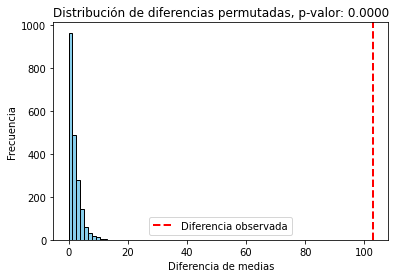

In [46]:

# Graficar la distribución de las diferencias permutadas
plt.hist(chi2_permutados, bins=10, color='skyblue', edgecolor='black')
plt.axvline(chi2_obs, color='red', linestyle='dashed', linewidth=2, label='Diferencia observada')
plt.title(f'Distribución de diferencias permutadas, p-valor: {p_valor:.4f}')
plt.xlabel('Diferencia de medias')
plt.ylabel('Frecuencia')
plt.legend()
plt.show()